# Direct Preference Optimization (DPO) on LLM

In [1]:
!pip install transformers accelerate datasets trl bitsandbytes -q

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

import os
os.environ["WANDB_DISABLED"] = "True"

# Load Dataset

In [3]:
# from datasets import Dataset

# data = [{
#         "chosen": [{"content": "Write me a poem", "role": "user"}, {"content": "Poeeeeeeeem", "role": "assistant"}],
#         "rejected": [{"content": "Write me a poem", "role": "user"}, {"content": "I don't know", "role": "assistant"}],
#         "score_chose": 7,
#         "score_rejected": 2
# }]
# dataset = Dataset.from_list(data)
# dataset

In [4]:
from datasets import load_dataset

dataset = load_dataset("trl-lib/ultrafeedback_binarized", split="train[:50]")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['chosen', 'rejected', 'score_chosen', 'score_rejected'],
    num_rows: 50
})

# Load Model

In [5]:
!rm -rf /content/Qwen/ #!rm -rf /content/EleutherAI/

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model

# Load model and tokenizer
model_name = "Qwen/Qwen2-0.5B-Instruct" #"EleutherAI/gpt-neo-125m"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj"]
)

model = get_peft_model(model, lora_config)

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
# if tokenizer.pad_token is None:
#   tokenizer.pad_token = tokenizer.eos_token

# if tokenizer.chat_template is None:
#   tokenizer.chat_template = """{% for message in messages %}
# {% if message['role'] == 'user' %}
# User: {{ message['content'] }}
# Assistant:
# {% elif message['role'] == 'assistant' and not loop.last %}
# {{ message['content'] }}
# {% endif %}
# {% endfor %}
# """

Let's see model predictions

In [8]:
for item in dataset.select(range(1)):
    full_prompt = tokenizer.apply_chat_template(
      item["chosen"],
      tokenize=False,
      add_generation_prompt=True  # important to add assistant's turn
    )
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=100, eos_token_id=tokenizer.eos_token_id)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True), "\n", "---"*5)

system
You are a helpful assistant.
user
Use the pygame library to write a version of the classic game Snake, with a unique twist
assistant
Sure, I'd be happy to help you write a version of the classic game Snake using the pygame library! Here's a basic outline of how we can approach this:

1. First, we'll need to set up the game display and create a game object that we can use to handle the game's state.
2. Next, we'll create the game's grid, which will be used to represent the game board. We'll need to define the size of the grid and the spaces within it.
3. After that, we'll create the snake object, which will be used to represent the player's movement. We'll need to define the size of the snake and the speed at which it moves.
4. We'll also need to create a food object, which will be used to represent the food that the player must collect to score points. We'll need to define the location of the food and the speed at which it moves.
5. Once we have these objects set up, we can star

# Fine-Tuning: Direct-Preference Optimization (DPO)

Training setup uses batch size = 1 due to my GPU limitations (Google Colab free). No succesful learning is done. Loss function states around log(2) which means no distinction between chosen and rejected. Loss function noise to values < log(2) is due to examples where the model succesfully differentiate and where it effectively learns.

More work to be done here.

In [9]:
from trl import DPOConfig, DPOTrainer

training_args = DPOConfig(
  output_dir=model_name,
  logging_steps=1,
  logging_strategy="steps",
  num_train_epochs=5,
  report_to=None,

  per_device_train_batch_size=1,          # Minimize batch size
  gradient_accumulation_steps=8,          # Accumulate to simulate larger batch
  bf16=True,                              # Or fp16=True depending on GPU support
)

trainer = DPOTrainer(
  model=model,
  args=training_args,
  processing_class=tokenizer,
  train_dataset=dataset
)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
1,0.693100
2,0.679000
3,0.709100
4,0.694300
5,0.693700
6,0.689700
7,0.181300
8,0.678000
9,0.670900
10,0.707600


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=35, training_loss=0.6217447446925299, metrics={'train_runtime': 425.923, 'train_samples_per_second': 0.587, 'train_steps_per_second': 0.082, 'total_flos': 0.0, 'train_loss': 0.6217447446925299, 'epoch': 5.0})

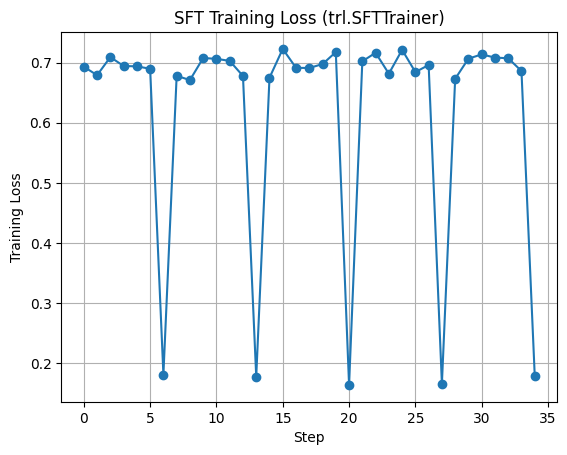

In [13]:
import json
import matplotlib.pyplot as plt

json_trainer_path = "/content/Qwen/Qwen2-0.5B-Instruct/checkpoint-35/trainer_state.json"#"/content/EleutherAI/gpt-neo-125m/checkpoint-35/trainer_state.json"
logs = json.load(open(json_trainer_path, "r"))

losses = [entry["loss"] for entry in logs["log_history"] if "loss" in entry]
steps = list(range(len(losses)))

plt.plot(steps, losses,"-o")
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("SFT Training Loss (trl.SFTTrainer)")
plt.grid()
plt.show()

In [14]:
for item in dataset.select(range(1)):
    full_prompt = tokenizer.apply_chat_template(
      item["chosen"],
      tokenize=False,
      add_generation_prompt=True  # important to add assistant's turn
    )
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=20, eos_token_id=tokenizer.eos_token_id,)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

system
You are a helpful assistant.
user
Use the pygame library to write a version of the classic game Snake, with a unique twist
assistant
Sure, I'd be happy to help you write a version of the classic game Snake using the pygame library! Here's a basic outline of how we can approach this:

1. First, we'll need to set up the game display and create a game object that we can use to handle the game's state.
2. Next, we'll create the game's grid, which will be used to represent the game board. We'll need to define the size of the grid and the spaces within it.
3. After that, we'll create the snake object, which will be used to represent the player's movement. We'll need to define the size of the snake and the speed at which it moves.
4. We'll also need to create a food object, which will be used to represent the food that the player must collect to score points. We'll need to define the location of the food and the speed at which it moves.
5. Once we have these objects set up, we can star